In [1]:
#Usual Imports
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

#Imports for Modelling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, \
                            AdaBoostClassifier, \
                            VotingClassifier, \
                            RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor, XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

#Imports for Cleaning
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re
import string
from sklearn.feature_extraction import text 
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer 

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, accuracy_score

pd.options.display.max_columns = 2000
pd.options.display.max_rows = 2000

pd.set_option('display.max_colwidth',1000)

# Problem Statement 

Fantasy vs Sci Fi Subreddits: 
Which model will accurately differentiate between these two subreddits ?

The definition of  a successful model is described by looking at two metrics of evaluation. The first metric is the variance between the training and testing accuracy scores, in other words whether overfitting occurs. The second metric is looking at the testing score, looking at models with the highest testing score.


# Data Cleaning 

In [2]:
df = pd.read_csv('./scifi and fantasy subreddits')

In [3]:
df.drop(columns = ['Unnamed: 0', 'created_utc'], inplace = True)

In [4]:
#Looking at the selftext column

In [5]:
df['selftext'] = df['selftext'].astype(str)

In [6]:
df['selftext'] = df['selftext'].replace('http\S+', '', regex=True).replace('www\S+', '', regex=True).replace('\n\n\S+', '', regex=True).replace('\n|S+', '', regex = True)

In [7]:
#Looking at the title column

In [8]:
df['title'] = df['title'].astype(str)

In [9]:
df['title'] = df['title'].replace('http\S+', '', regex=True).replace('www\S+', '', regex=True).replace('\n\n\S+', '', regex=True).replace('\n|S+', '', regex = True)

In [10]:
#Dropping Duplicates

In [11]:
df.drop_duplicates(inplace = True )
df.duplicated().sum()

0

In [12]:
#Changing Subreddit column, 1 for Fantasy and 0 for Science Fiction

In [13]:
df['subreddit'] = df['subreddit'].map({'Fantasy':1,'AskScienceFiction':0})

In [14]:
df['subreddit'].value_counts(normalize = True)

0    0.500214
1    0.499786
Name: subreddit, dtype: float64

##### Discussion:  
We are able to see above that our data is very well balanced. Our model will have to do better by scoring a score higher than 0.5. 

In [15]:
#Exporting clean df for extra precautions
#df.to_csv('./cleaned selftext csv')

In [16]:
df['status_word_count'] = [len(i.split()) for i in df['selftext']]

In [17]:
#Dropping cells with no text.

In [18]:
zero_text = df[df['status_word_count']==0]

In [19]:
df.drop(zero_text.index, inplace = True)

In [20]:
#Dropping cells with minimum text.

In [21]:
one_text = df[df['status_word_count']==1]

In [22]:
df.drop(one_text.index, inplace = True)

##### Discussion:  

I have cleaned the data by looking at missing values. The while loop used to extract the post has been coded in order to drop rows that contained 'deleted' or 'removed' posts. None the less, it was still a good idea to check whether or not some posts were missing. After creating the column containing the word count, I filtered the data frame for words less than or equal to 1. I found out that couple posts were completely irrelevant to the subreddit therefore I decided to drop them.  

# EDA

In [142]:
df.dtypes

subreddit             int64
title                object
selftext             object
status_word_count     int64
dtype: object

In [134]:
#Looking at the average word count

Text(0.5, 0, 'Word Count')

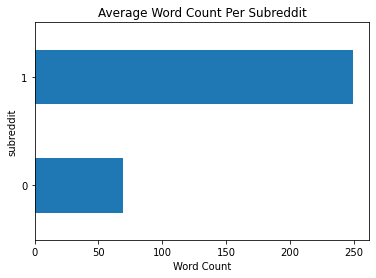

In [23]:
df.groupby('subreddit')['status_word_count'].mean().plot(kind = 'barh',title='Average Word Count Per Subreddit')
plt.xlabel('Word Count')


In [ ]:
# Fantasy histogram of the word counts with a limit of 300 words

Text(0, 0.5, 'Frequency')

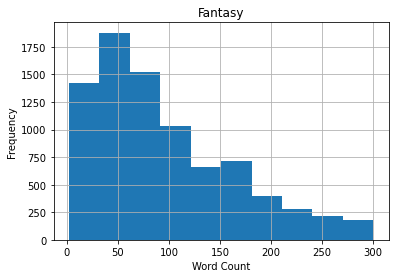

In [135]:
df_hist_1 = df[(df['subreddit']==1 )& (df['status_word_count']<=300)]
df_hist_1.hist(column= ['status_word_count']) 
plt.title('Fantasy')
plt.xlabel('Word Count')
plt.ylabel('Frequency')


In [ ]:
#Sci Fi histogram of the word counts with a limit of 200 words

Text(0, 0.5, 'Frequency')

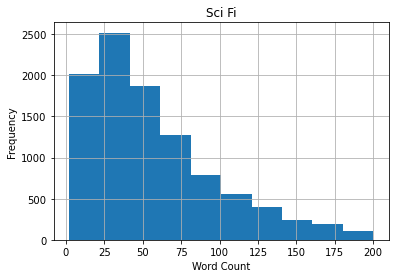

In [137]:
df_hist_0 = df[(df['subreddit']==0 )& (df['status_word_count']<=200)]
df_hist_0.hist(column= ['status_word_count']) 
plt.title('Sci Fi')
plt.xlabel('Word Count')
plt.ylabel('Frequency')


In [ ]:
# Fantasy histogram of the word counts with a limit of 1000 words

Text(0, 0.5, 'Frequency')

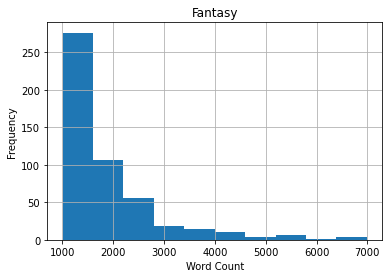

In [28]:
df_hist_1 = df[(df['subreddit']==1 )& (df['status_word_count']>1000)]
df_hist_1.hist(column= ['status_word_count']) 
plt.title('Fantasy')
plt.xlabel('Word Count')
plt.ylabel('Frequency')


In [ ]:
#Sci Fi histogram of the word counts with a limit of 1000 words

Text(0, 0.5, 'Frequency')

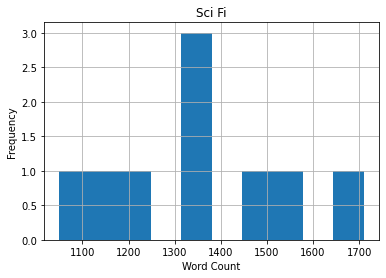

In [30]:
df_hist_0 = df[(df['subreddit']==0 )& (df['status_word_count']>1000)]
df_hist_0.hist(column= ['status_word_count']) 
plt.title('Sci Fi')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

##### Discussion:  

We are able to see from the graph above that the Fantasy subreddit word count per post is greater than Sci fi. On average, Fantasy has 250 words while Sci fi has an average of 69 words. Next we look at the distribution of the word count for the two subreddits. The first histogram shows the distribution for the fantasy subreddit while the second histogram shows the distribution for the Sci fi subreddit. The status word count was limited to the number of words per average of each subreddit. That means that the histogram portraying the Fantasy subreddit was limited to 300 words while the subreddit portraying the Sci fi subreddit was limited to 200 words.  Both histograms appear to follow a similar distribution, both being skewed to the right.  Exploring my data I also found that several posts had word counts that exceeded the 1,000 words. At first I classified those as outliers and decided to drop them. After doing so, I realized that it was unfavorable as my test score accuracy dropped. As a result, I decided to keep them. As it can be seen in the two last histograms above, Fantasy contains a lot more posts than Sci Fi with a word count of 1,000. As I explored the data I found out that a lot of these posts were book reviews. This is one of the reasons I also decided to keep them. Overall, after exploring the necessary data I came to the conclusion that the data frame includes enough observations to answer the problem statement. 

# Modelling the Data

In [47]:
#Setting our features and target variable
X = df['selftext']
y = df['subreddit']

In [48]:
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 42)

In [49]:
# Adding Stop Words

In [50]:
my_stop_words = ['rfantasy','science fiction','fantasy']
stop_words = text.ENGLISH_STOP_WORDS.union(my_stop_words)


##### Discussion:  
I am including stop words to my count and TFIDF vectorizers. To these stop words, I am adding my own list of stop words. These include: rfantasy, science fiction, fantasy. In order to make my model more realistic, I chose to add these words as stop words. This way, the model will chose other words that are less bias when classifying the posts. 

In [51]:
#Initializing Count Vectorizer

In [52]:
cvec = CountVectorizer(stop_words = stop_words)

In [53]:
Xcvec_train = cvec.fit_transform(X_train)
Xcvec_test = cvec.transform(X_test)

In [54]:
df_X_train = pd.DataFrame(Xcvec_train.todense(), columns=cvec.get_feature_names())

Text(0, 0.5, 'Word')

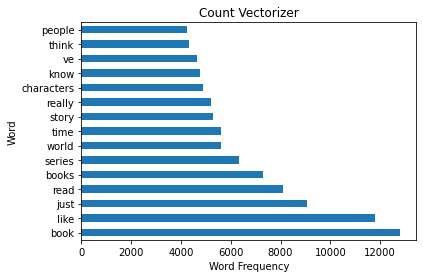

In [55]:
df_X_train.sum().sort_values(ascending=False).head(15).plot(kind='barh');
plt.title('Count Vectorizer')
plt.xlabel('Word Frequency')
plt.ylabel('Word')


In [56]:
#Initializing TFIDF Vecotorizer

In [57]:
tfid = TfidfVectorizer(stop_words = stop_words)

In [58]:
Xtfid_train = tfid.fit_transform(X_train)
Xtfid_test = tfid.transform(X_test)

In [59]:
tfid_X_train = pd.DataFrame(Xtfid_train.todense(), columns=cvec.get_feature_names())

In [60]:
weight_values = Xtfid_test[0]

Text(0, 0.5, 'Word')

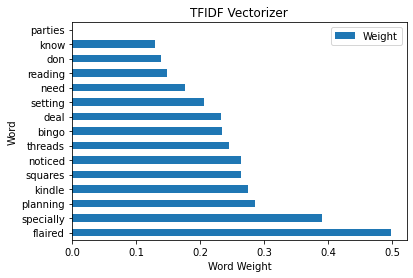

In [138]:
df_tfid_weight = pd.DataFrame(weight_values.todense().T, index  = tfid.get_feature_names(),columns = ['Weight'])
df_tfid_weight.sort_values(by = ['Weight'],ascending = False).head(15).plot(kind = 'barh');
plt.title('TFIDF Vectorizer')
plt.xlabel('Word Weight')
plt.ylabel('Word')

##### Discussion:  
Looking at the two diagrams portraying the top 15 words for count vectorizer and TFIDF vectorizer we can observe that the words are very different from one another. Count vectorizer classifies the top 15 words in terms of frequency, those are the 15 words that were observed the most in the data frame. On the other hand TFIDF weighting takes into consideration the frequency of the word but also in how many posts it appears in order to calculate its weight of importance. We can expect to get different results using count vectorizer and tfidf vectorizer.

### Looking at Random Forests

In [64]:
#Fitting our Count Vectorizer first

In [85]:
rfc = RandomForestClassifier()

In [86]:
rfc.fit(Xcvec_train, y_train)

RandomForestClassifier()

In [87]:
rfc.score(Xcvec_train,y_train), rfc.score(Xcvec_test,y_test)

(0.9995408330600197, 0.9167650531286895)

In [101]:
#Gridsearching to find the most optimal hyperparameters

In [115]:
params = {'n_estimators': [200,300],
         'min_samples_split': [3,4],
         'min_samples_leaf': [2,3],
         'max_features': ['auto'],
         }

In [116]:
gs = GridSearchCV(rfc,param_grid = params,cv = 3,verbose = 3)

In [117]:
gs.fit(Xcvec_train,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=  25.3s
[CV 2/3] END max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=  31.4s
[CV 3/3] END max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=  30.7s
[CV 1/3] END max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=  37.8s
[CV 2/3] END max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=  36.2s
[CV 3/3] END max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=300; total time=  36.4s
[CV 1/3] END max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=  24.9s
[CV 2/3] END max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=  25.0s
[CV 3/3] END max_features=auto, min_samples_leaf=2, min_samp

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_features': ['auto'], 'min_samples_leaf': [2, 3],
                         'min_samples_split': [3, 4],
                         'n_estimators': [200, 300]},
             verbose=3)

In [63]:
#Tuning our Model

In [121]:
gs.best_estimator_

RandomForestClassifier(min_samples_leaf=2, min_samples_split=3,
                       n_estimators=200)

In [78]:
rfc_best = RandomForestClassifier(
 min_samples_leaf= 2,
 min_samples_split= 3,
 n_estimators= 200)

In [79]:
rfc_best.fit(Xcvec_train, y_train)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=3,
                       n_estimators=200)

In [81]:
rfc_best.score(Xcvec_train,y_train), rfc_best.score(Xcvec_test,y_test)

(0.9530910021758607, 0.9328086004991362)

Text(0, 0.5, 'Word')

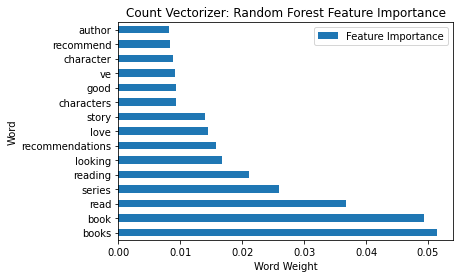

In [83]:
data = {'Word':df_X_train.columns,'Feature Importance':rfc_best.feature_importances_}
dataf = pd.DataFrame(data)
dataf = dataf.sort_values(by = ['Feature Importance'],ascending = False).head(15)
dataf.plot.barh(x='Word', y='Feature Importance')
plt.title('Count Vectorizer: Random Forest Feature Importance')
plt.xlabel('Word Weight')
plt.ylabel('Word')

In [91]:
#Modelling using our TFIDF with tuned hyperparameters

In [73]:
rfc_tfid = RandomForestClassifier(min_samples_leaf= 2,
 min_samples_split= 3,
 n_estimators= 200)

In [74]:
rfc_tfid.fit(Xtfid_train,y_train)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=3,
                       n_estimators=200)

In [82]:
rfc_tfid.score(Xtfid_train,y_train), rfc_tfid.score(Xtfid_test,y_test)

(0.9713938307948291, 0.9404876175849491)

Text(0, 0.5, 'Word')

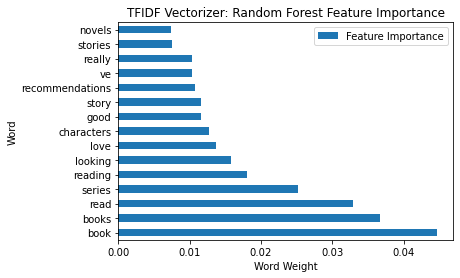

In [75]:
d = {'Word':tfid_X_train.columns,'Feature Importance':rfc_tfid.feature_importances_}
fi = pd.DataFrame(d)
fi = fi.sort_values(by = ['Feature Importance'],ascending = False).head(15)
fi.plot.barh(x='Word', y='Feature Importance')
plt.title('TFIDF Vectorizer: Random Forest Feature Importance')
plt.xlabel('Word Weight')
plt.ylabel('Word')

##### Discussion:  

In this section of the notebook we run our first model, Random Forests. At first, we run the model using count vectorizer with default parameters. Next we use a grid-search in order to further tune our hyper-parameters. Once the grid-search showed the best parameters, we fitted a tuned model. The tuned model gave a more desirable score with train score equivalent to 0.953 and test score equivalent to 0.931.What this means is that taking our train score, our model is able to explain 97.1% of the variance in our model. With that said, the variance between the train and test score is about 0.02. The next step was to fit the tuned model using TFIDF vectorizer. The train and test score are different from the model with the count vectorizer. The train and test score appeared to have increased and the variance between two scores has increased. Taking the train score into consideration, the model is able to explain 97.1% of the variance in our model. The variance between the train and test score is about 0.03. Although the variance increased, these two scores are more desirable as they are higher. Next we plot the feature importance for both the count vectorizer and the TFIDF vectorizer. Both plots appear to be very similar to one another, giving importance to approximately the same words. The only words that appear different are the first three words on the plot(having the smallest weights). It is interesting to see that the heaviest weighted words are exactly the same for count vectorizer and TFIDF vectorizer. 

### Looking at XGBoost

In [365]:
#Fitting our Count Vectorizer first

In [84]:
xgb = XGBClassifier()

In [85]:
xgb.fit(Xcvec_train, y_train)

/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:13:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [86]:
xgb.score(Xcvec_train, y_train), xgb.score(Xcvec_test, y_test)

(0.9477793421221042, 0.9285851411019389)

In [ ]:
#GridSearching over the most optimal hyperparameters

In [254]:
params_boost = {
    'max_depth':[3,4,5],
    'n_estimators':[100,200,300],
    'min_child_weight':[1,2,3]
}

In [255]:
gs_boost = GridSearchCV(xgb,param_grid = params_boost,cv = 2,verbose = 3)

In [256]:
gs_boost.fit(Xcvec_train,y_train)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[20:33:05] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/2] END max_depth=3, min_child_weight=1, n_estimators=100; total time=   4.2s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:33:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END max_depth=3, min_child_weight=1, n_estimators=100; total time=   4.3s
[20:33:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/2] END max_depth=3, min_child_weight=1, n_estimators=200; total time=   8.2s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:33:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END max_depth=3, min_child_weight=1, n_estimators=200; total time=   9.5s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:33:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END max_depth=3, min_child_weight=1, n_estimators=300; total time=  12.0s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:33:44] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END max_depth=3, min_child_weight=1, n_estimators=300; total time=  12.3s
[20:33:56] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/2] END max_depth=3, min_child_weight=2, n_estimators=100; total time=   4.2s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:34:00] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END max_depth=3, min_child_weight=2, n_estimators=100; total time=   4.5s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:34:05] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END max_depth=3, min_child_weight=2, n_estimators=200; total time=   7.8s
[20:34:12] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/2] END max_depth=3, min_child_weight=2, n_estimators=200; total time=   7.9s
[20:34:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/2] END max_depth=3, min_child_weight=2, n_estimators=300; total time=  11.5s
[20:34:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/2] END max_depth=3, min_child_weight=2, n_estimators=300; total time=  11.6s
[20:34:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[CV 1/2] END max_depth=3, min_child_weight=3, n_estimators=100; total time=   4.1s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:34:48] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END max_depth=3, min_child_weight=3, n_estimators=100; total time=   4.3s
[20:34:52] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/2] END max_depth=3, min_child_weight=3, n_estimators=200; total time=   7.8s
[20:35:00] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/2] END max_depth=3, min_child_weight=3, n_estimators=200; total time=   7.8s
[20:35:07] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/2] END max_depth=3, min_child_weight=3, n_estimators=300; total time=  11.4s
[20:35:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/2] END max_depth=3, min_child_weight=3, n_estimators=300; total time=  11.5s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END max_depth=4, min_child_weight=1, n_estimators=100; total time=   4.6s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END max_depth=4, min_child_weight=1, n_estimators=100; total time=   4.7s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END max_depth=4, min_child_weight=1, n_estimators=200; total time=   8.9s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:49] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END max_depth=4, min_child_weight=1, n_estimators=200; total time=   9.0s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:58] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END max_depth=4, min_child_weight=1, n_estimators=300; total time=  13.7s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END max_depth=4, min_child_weight=1, n_estimators=300; total time=  13.2s
[20:36:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/2] END max_depth=4, min_child_weight=2, n_estimators=100; total time=   4.7s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END max_depth=4, min_child_weight=2, n_estimators=100; total time=   4.6s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END max_depth=4, min_child_weight=2, n_estimators=200; total time=   8.7s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END max_depth=4, min_child_weight=2, n_estimators=200; total time=   8.7s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:51] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END max_depth=4, min_child_weight=2, n_estimators=300; total time=  13.0s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:37:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END max_depth=4, min_child_weight=2, n_estimators=300; total time=  13.2s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:37:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END max_depth=4, min_child_weight=3, n_estimators=100; total time=   4.6s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:37:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END max_depth=4, min_child_weight=3, n_estimators=100; total time=   4.6s
[20:37:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/2] END max_depth=4, min_child_weight=3, n_estimators=200; total time=   8.8s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:37:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END max_depth=4, min_child_weight=3, n_estimators=200; total time=   9.3s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:37:45] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END max_depth=4, min_child_weight=3, n_estimators=300; total time=  12.9s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:37:58] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END max_depth=4, min_child_weight=3, n_estimators=300; total time=  14.1s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:38:12] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END max_depth=5, min_child_weight=1, n_estimators=100; total time=   5.4s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:38:17] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END max_depth=5, min_child_weight=1, n_estimators=100; total time=   5.5s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:38:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END max_depth=5, min_child_weight=1, n_estimators=200; total time=  10.2s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:38:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END max_depth=5, min_child_weight=1, n_estimators=200; total time=  10.0s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:38:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END max_depth=5, min_child_weight=1, n_estimators=300; total time=  15.9s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:38:59] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END max_depth=5, min_child_weight=1, n_estimators=300; total time=  14.9s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:39:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END max_depth=5, min_child_weight=2, n_estimators=100; total time=   5.2s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:39:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END max_depth=5, min_child_weight=2, n_estimators=100; total time=   5.3s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:39:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END max_depth=5, min_child_weight=2, n_estimators=200; total time=   9.8s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:39:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END max_depth=5, min_child_weight=2, n_estimators=200; total time=  10.0s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:39:44] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END max_depth=5, min_child_weight=2, n_estimators=300; total time=  14.6s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:39:59] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END max_depth=5, min_child_weight=2, n_estimators=300; total time=  15.0s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:40:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END max_depth=5, min_child_weight=3, n_estimators=100; total time=   5.3s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:40:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END max_depth=5, min_child_weight=3, n_estimators=100; total time=   5.1s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:40:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END max_depth=5, min_child_weight=3, n_estimators=200; total time=   9.9s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:40:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END max_depth=5, min_child_weight=3, n_estimators=200; total time=   9.8s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:40:44] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END max_depth=5, min_child_weight=3, n_estimators=300; total time=  14.5s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:40:59] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END max_depth=5, min_child_weight=3, n_estimators=300; total time=  14.7s


/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:41:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=4,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=0.5,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
       

In [257]:
gs_boost.best_params_

{'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300}

In [65]:
xgb_best = XGBClassifier(max_depth = 5,min_child_weight = 1, n_estimators = 300)

In [66]:
xgb_best.fit(Xcvec_train, y_train)

/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:14:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [67]:
xgb_best.score(Xcvec_train, y_train), xgb_best.score(Xcvec_test, y_test)

(0.965826187124024, 0.9366481090420427)

Text(0, 0.5, 'Word')

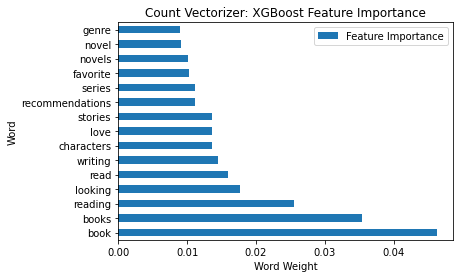

In [89]:
t1 = {'Word':df_X_train.columns,'Feature Importance':xgb_best.feature_importances_}
f1 = pd.DataFrame(t1)
f1 = f1.sort_values(by = ['Feature Importance'],ascending = False).head(15)
f1.plot.barh(x='Word', y='Feature Importance')
plt.title('Count Vectorizer: XGBoost Feature Importance')
plt.xlabel('Word Weight')
plt.ylabel('Word')

In [369]:
#Modelling with TFIDF Vecotorizer using tuned hyperparameters

In [96]:
xgb_tfid = XGBClassifier(max_depth= 5, min_child_weight= 1, n_estimators= 300)

In [97]:
xgb_tfid.fit(Xtfid_train,y_train)

/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:56] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [98]:
xgb_tfid.score(Xtfid_train,y_train), xgb_tfid.score(Xtfid_test,y_test)

(0.9760655318059644, 0.935688231906316)

Text(0, 0.5, 'Word')

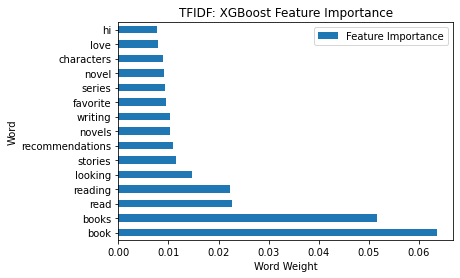

In [91]:
t = {'Word':tfid_X_train.columns,'Feature Importance':xgb_tfid.feature_importances_}
f = pd.DataFrame(t)
f = f.sort_values(by = ['Feature Importance'],ascending = False).head(15)
f.plot.barh(x='Word', y='Feature Importance')
plt.title('TFIDF: XGBoost Feature Importance')
plt.xlabel('Word Weight')
plt.ylabel('Word')

##### Discussion:

We look at our next model, XG Boost. In the first part of this section we explore our model with count vectorizer and default parameters. Our model scores a reasonable score for both train and test with scores equivalent to 0.965 and 0.936 respectively. This means that taking the training score into consideration, our model can explain 96.5% of the variance. The variance between the two scores is approximately 0.02. After running a grid-search and applying the best hyper-parameters, we can see that both our train and test scores increase. As our scores increase to 0.976 and 0.936 respectively, so does the variance to 0.03. We then look at our TFIDF vectorizer using the tuned hyper-parameters. The variance between the train and the test scores is the greatest so far it is approximately 0.04. With that said the train score scored higher than the count vectorizer, it is equivalent to 0.976. The test score is equivalent to 0.935. Taking the train score into consideration, this shows that the model can explain 97.6% of the variance. Interestingly, the testing score appeared to have decreased. For more comparison, a visual representation of the feature importance for both the count vectorizer and TFIDF vectorizer are presented above. Similar to Random Forests, we can see that the most weighted words are very similar for Count and TFIDF vectorizers. On the other hand the least weighted words at the top of the plots appear to be different from one another. 

### Looking at Naive Bayes

In [374]:
#Looking at TFID

In [107]:
nb = MultinomialNB()

In [108]:
nb.fit(Xtfid_train,y_train)

MultinomialNB()

In [109]:
nb.score(Xtfid_train,y_train), nb.score(Xtfid_test,y_test)

(0.9480353257391527, 0.9174505663275101)

In [110]:
nb = MultinomialNB(alpha = 0.55)

In [111]:
nb.fit(Xtfid_train,y_train)

MultinomialNB(alpha=0.55)

In [112]:
nb.score(Xtfid_train,y_train), nb.score(Xtfid_test,y_test)

(0.9607065147830539, 0.9295450182376656)

/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


Text(0, 0.5, 'Word')

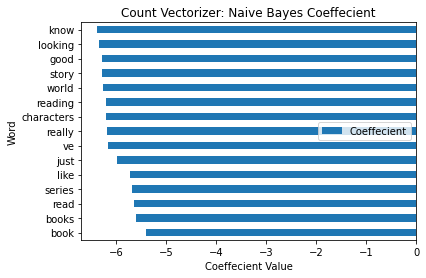

In [102]:
l1 = {'Word':df_X_train.columns,'Coeffecient':nb.coef_[0].T}
h1 = pd.DataFrame(l1)
h1 = h1.sort_values(by = ['Coeffecient'],ascending = False).head(15)
h1.plot.barh(x='Word', y='Coeffecient')

plt.title('Count Vectorizer: Naive Bayes Coeffecient')
plt.xlabel('Coeffecient Value')
plt.ylabel('Word')

In [378]:
#Looking at CVEC

In [113]:
nb = MultinomialNB()

In [114]:
nb.fit(Xcvec_train,y_train)

MultinomialNB()

In [115]:
nb.score(Xcvec_train,y_train), nb.score(Xcvec_test,y_test)

(0.9553308588250352, 0.934536379343444)

In [104]:
nb.fit(Xcvec_train,y_train)

MultinomialNB(alpha=0.55)

In [105]:
nb.score(Xcvec_train,y_train), nb.score(Xcvec_test,y_test)

(0.9609624984001024, 0.9383758878863505)

/Users/ajk/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


Text(0, 0.5, 'Word')

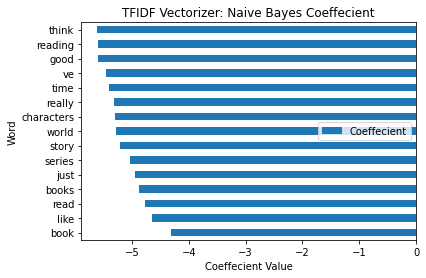

In [106]:

l = {'Word':tfid_X_train.columns,'Coeffecient':nb.coef_[0].T}
h = pd.DataFrame(l)
h = h.sort_values(by = ['Coeffecient'],ascending = False).head(15)
h.plot.barh(x='Word', y='Coeffecient')

plt.title('TFIDF Vectorizer: Naive Bayes Coeffecient')
plt.xlabel('Coeffecient Value')
plt.ylabel('Word')

##### Discussion:

Finally we look at our last model, Naive Bayes. This time no grid-searching has been used. Alpha has been set to 0.55, as I found out by hand that it gave out the best scores. Looking at the count vectorizer first, after tuning the model we get a score of 0.961 for the training score and 0.938 for the testing score. Taking the training score into consideration, this means that our model can account for 96.1% of the variance. Next looking at the TFIDF vectorizer we can see that the train score is equivalent to 0.961 and the test score equivalent to 0.929. What this shows is that taking the training score into consideration, our model accounts for 96.1% of the variance. These scores are very similar to the count vectorizer, in fact our testing score decreased when using TFIDF vectorizer. In order to better contrast these two models, I have plotted the coefficient importance for both count and TFIDF vectorizers. Interestingly, all of our coefficients are negative. With that said the highest scoring coefficients appear to be similar for our two models, although the order at which they are presented appears to differ. 

# Conclusion & Analysis

In order to effectively answer: what model will best classify the subreddits as Fantasy or Science Fiction I divided this task into two notebooks. The first notebook collected data by scraping a subreddit API. Because I was only able to scrape 100 posts at a time, I effectively made a while loop that would scrape 10,000 posts for each subreddits. The loop dropped any posts that contained 'deleted' or 'removed'. Finally the posts were combined into a data frame and exported as a csv. The second notebook is where the modelling took place. The first step taken to answer the question was to further clean the data by removing outliers and any unwanted punctuations. EDA was then performed on the data in order to effectively understand patterns. The last step was to make various models using both count vectorizer and TFIDF vectorizer. Once all these models fitted, all that was left was to compare them together in order to find the best one.

Looking at all 6 of the models, the model that best classifies the subreddits into either Fantasy or Science Fiction is the Random Forests using TFIDF Vectorizer. This was chosen as the best model for the following reasons. Taking training scores into consideration, the model did not score the highest. The highest scoring model after tuning was the XG Boost using TFIDF vectorizer. It scored a training score of 0.976. With that said the TFIDF Random Forest model had a slightly lower training score of 0.971. What makes the difference between these two models is the testing score. The Random Forest model is the model that scored the highest in terms of testing score,0.94, and that is one of the metrics by which I evaluated these models. Scoring high on unseen data shows how well a model really does. The other metric by which I chose this model was the low variance between training and testing, it is equivalent to approximately 0.03. Although it is slightly overfit, the variance is low enough to accept the model. With that said although it only scored as the second highest for training score, TFIDF Random Forest model scored the highest in testing score and was therefore chosen as the best model.

##### Making Predictions using our Best Model

Text(0.5, 1.0, 'TFIDF Random Forests: Confusion Matrix')

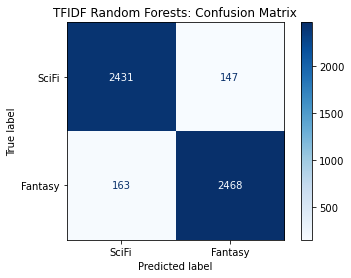

In [123]:

plot_confusion_matrix(rfc_tfid, Xtfid_test,y_test, cmap = 'Blues',display_labels = ['SciFi','Fantasy',])
plt.title('TFIDF Random Forests: Confusion Matrix')

In [139]:
preds = rfc_tfid.predict(Xtfid_test)
tn,fp,fn,tp = confusion_matrix(y_test,preds).ravel()

#Sensitivity/Recall: How well is our model able to detect our subreddit in its correct class ?
print('Sensitivity:', 2472/(2472+159))
#Accuracy: What percentage of our observations did we succesfully predict ?
print('Accuracy:',accuracy_score(y_test, preds))
#Precision: How well did our model predict Fantasy classes ?
print('Precision:',precision_score(y_test,preds))
#Specificity : How well did our model predict Sci Fi classes ?
spec = tn/(tn+fp)
print('Specificity :',spec)

Sensitivity: 0.9395667046750285
Accuracy: 0.9404876175849491
Precision: 0.9437858508604207
Specificity : 0.9429790535298681


##### Continued: 
Now that we have chosen our best model, we can evaluate how good it is at classification. Plotting a confusion matrix we can see that our model does pretty well at classifying our subreddits. This can be further justified by looking at the precision and specificity score. Precision outlines how well did the model predict Fantasy classes, it scored 94.3%. While specificity outline how well did the model predict Sci Fi classes, it scored about 94.3% as well.What this means is that the model does an equivalent job at classifying a Fantasy and a Science Fiction subreddit. This can be further explained by reminding our audience that the data was well balanced. Next looking at the accuracy of the model, we can see that the model is able to successfully predict 94% of the observations. This remains a high scoring model and is accepted  as the model that best answers the problem statement. Overall, it is concluded that this investigation has successfully addressed and answered the problem statement of finding the best model at classifying posts into  Fantasy or Science Fiction subreddits. 

##### Recommendations:

After choosing the best model for my specific problem statement, this can be taken a step further. A model that takes in all the subreddits would be used to make recommendations to users on what subreddits they could posts their thread. For instance, if a user posts a thread in the AskScienceFiction subreddit, the model incorporated  would classify if the posts is best suited for that subreddit in particular. The model would take the post and predict in which subreddit it falls best. If the post is not suited for that subreddit, the model will make recommendations on where the user should post their thread, for instance on the Fantasy subreddit. Doing so will increase user commitment, engagement and satisfaction. As well as further accommodate users (to better respond to their needs).